In [1]:
import ROOT as rt
from root_numpy import root2array, tree2array

#import os
#os.environ['OPENBLAS_NUM_THREADS'] = '1'
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import math

from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import seaborn as sns
from scipy.stats import ks_2samp
from scipy import stats

from xgboost import XGBClassifier
import random

import pickle

Welcome to JupyROOT 6.28/04


ImportError: libCore.so.6.24: cannot open shared object file: No such file or directory

In [2]:
def convert(tree, selections):
    feature = tree2array(tree,
                        branches = wt_variables + variables + mass_variables,
                        selection = selections
                        )
    return feature


def convert_ntuple_dataframe(path, filename,treename, selections="H_mass>100 && H_mass<180 && ((abs(gamma_eta)<1.4442 && gamma_mvaID > -0.4) | (abs(gamma_eta)>1.566 && gamma_mvaID > -0.59))"):
    rootfile = rt.TFile.Open(path+filename)
    tree = rootfile.Get(treename)
    np =convert(tree, selections)
    dataframe = pd.DataFrame.from_records(np)
    return dataframe, tree

def compare_train_test(clf,x_train,y_train,z_train,w_train,x_test,y_test,z_test,w_test, bins=50, label=''):
    
    # K-S Test
    y_test_pred = clf.predict_proba(x_test)[:, 1]
    y_train_pred = clf.predict_proba(x_train)[:, 1]
    
    y_test_frame = pd.DataFrame({'truth':z_test, 'disc':y_test_pred, 'label':y_test})
    y_train_frame = pd.DataFrame({'truth':z_train, 'disc':y_train_pred, 'label':y_train})

    disc_train_signal_all = y_train_frame[y_train_frame['truth'] < 0]['disc'].values
    disc_train_bkg_all = y_train_frame[y_train_frame['truth'] > 0]['disc'].values

    disc_test_signal_all = y_test_frame[y_test_frame['truth'] < 0]['disc'].values
    disc_test_bkg_all = y_test_frame[y_test_frame['truth'] > 0]['disc'].values

    # K-S test
    stat_signal,pval_signal = ks_2samp(disc_train_signal_all,disc_test_signal_all)
    stat_bkg,pval_bkg = ks_2samp(disc_train_bkg_all,disc_test_bkg_all)
    ######################
    
    
    fig = plt.figure(figsize=(5,5))
    plt.title(label)
    decisions = []
    weight    = []
    print(clf)
    for x,y,w in ((x_train, y_train, w_train), (x_test, y_test, w_test)):
        print(x.shape)
        d1 = clf.predict_proba(x[y>0.5])[:,1]
        d2 = clf.predict_proba(x[y<0.5])[:,1].ravel()
        #d1 = evaluate_sklearn(clf,x[y>0.5])
        #d2 = evaluate_sklearn(clf,x[y<0.5])
        w1 = w[y>0.5]
        w2 = w[y<0.5]
        decisions += [d1, d2]
        weight    += [w1, w2]
        
    low  = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    
    plt.hist(0,
             color='w', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True, 
             label='Sig (Bkg) K-S test p-value: {0:.2f}({1:.2f})'.format(pval_signal, pval_bkg))
    
    
    plt.hist(decisions[0],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             weights = weight[0], 
             label='S (train)')
    plt.hist(decisions[1],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             weights = weight[1], 
             label='B (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, density=True, weights = weight[2] )
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='.', c='b', label='S (test)', markersize=8,capthick=0)
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, density=True, weights = weight[3])
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='.', c='r', label='B (test)', markersize=8,capthick=0)

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    #plt.yscale('log')
    plt.legend(loc='best')
    plt.ylim([0.01, 2*max(hist)])
    #plt.savefig('./plot/BDT_output.png',dpi=300)
    plt.show()
    

In [3]:
# Di-jet
#variables = ['H_ptt', "l2g_deltaR", "gamma_mvaID", "delta_eta_jj", "pt_balance", "Z_cos_theta", "l1g_deltaR", "gamma_ptRelErr", "jet1G_deltaR", "delta_phi_jj", "jet_1_pt", "jet_2_pt", "jet2G_deltaR", "Z_lead_lepton_eta", "Z_sublead_lepton_eta", "gamma_eta", "photon_zeppenfeld", "lep_cos_theta", "delta_phi_zgjj", "lep_phi"]
# 0/1 jet
#variables = ['H_ptt', "l2g_deltaR", "gamma_mvaID", "Z_cos_theta", "l1g_deltaR", "gamma_ptRelErr", "Z_lead_lepton_eta", "Z_sublead_lepton_eta", "gamma_eta", "lep_cos_theta", "lep_phi"]
variables = ["Z_cos_theta", "lep_cos_theta", "H_relpt", "Z_lead_lepton_eta", "Z_sublead_lepton_eta", "gamma_eta", "lep_phi", "gamma_mvaID", "gamma_ptRelErr", "l1g_deltaR", "l2g_deltaR"]
#variables = ["l2g_deltaR", "gamma_mvaID", "Z_cos_theta", "l1g_deltaR", "gamma_ptRelErr", "Z_lead_lepton_eta", "Z_sublead_lepton_eta", "gamma_eta", "lep_cos_theta", "lep_phi"]
mass_variables = ['H_mass']
wt_variables = ['weight']

file_path = "/publicfs/cms/user/wangzebing/HZG/skimmed_ntuples"
bkg_name = ['DYJetsToLL', 'ZGToLLG']
sig_name = ['ggH', 'VBF']
data_name = ['data']
years = ['2017']
tree_name = "zero_to_one_jet"

dfs = {}
tree = {}
for year in years:
    dfs[year] = {}
    tree[year] = {}

    for dataset in bkg_name + sig_name + data_name:
        dfs[year][dataset], tree[year][dataset] = convert_ntuple_dataframe("{}/{}/".format(file_path,dataset),"{}.root".format(year), tree_name) 

df_sig_ggH = pd.concat([dfs[y]["ggH"] for y in years ])
df_sig_VBF = pd.concat([dfs[y]["VBF"] for y in years ])
df_sig_all = pd.concat([dfs[y][sig] for y in years for sig in sig_name ])
df_bkg_dy = pd.concat([dfs[y]["DYJetsToLL"] for y in years])
df_bkg_ZG = pd.concat([dfs[y]["ZGToLLG"] for y in years])
df_bkg_all = pd.concat([dfs[y][bkg] for y in years for bkg in bkg_name ])
df_data_all = pd.concat([dfs[y][dataset] for y in years for dataset in data_name ])
        

In [4]:
df_data_all

,weight,Z_cos_theta,lep_cos_theta,H_relpt,Z_lead_lepton_eta,Z_sublead_lepton_eta,gamma_eta,lep_phi,gamma_mvaID,gamma_ptRelErr,l1g_deltaR,l2g_deltaR,H_mass
0,1.0,0.643763,-0.050915,0.277651,-0.321777,-1.706299,0.135803,0.412039,-0.139038,0.018222,3.000791,2.267182,147.261871
1,1.0,-0.032262,-0.631901,0.323114,1.595459,0.170898,1.675049,-3.078343,0.779297,0.025916,3.685796,1.515656,115.196518
2,1.0,-0.549060,-0.463686,0.025124,-0.713013,0.480774,-1.268555,-0.157308,0.806152,0.038848,3.041042,1.769601,141.534180
3,1.0,-0.555606,0.571041,0.240605,0.447937,-0.541870,-0.254211,1.187383,0.955078,0.017857,1.966536,1.182021,101.488976
4,1.0,-0.521644,0.172990,0.044186,-2.446289,-0.457886,-2.409180,-0.604182,0.316650,0.043320,5.096586,2.480685,132.444153
...,...,...,...,...,...,...,...,...,...,...,...,...,...
132008,1.0,0.686062,-0.897919,0.247251,-0.353271,-0.778931,-0.159332,2.432162,-0.002541,0.014602,2.911069,0.812050,122.216240
132009,1.0,0.231308,0.132526,0.047665,-1.328125,-2.423828,-1.603516,-0.962124,-0.531738,0.061073,4.156350,1.722251,118.361473
132010,1.0,-0.795386,-0.200582,0.391178,-1.345459,-0.235443,-1.888672,-2.244671,0.611328,0.066289,4.752851,1.416073,125.091560
132011,1.0,0.293086,-0.786364,0.151563,-1.009033,0.335632,-0.473633,-0.603350,0.927734,0.015131,2.689092,1.051197,114.283089


Get sideband/signal region data

In [5]:
data_SB = df_data_all[( (df_data_all["H_mass"] > 100) & (df_data_all["H_mass"] < 120) ) | ( (df_data_all["H_mass"] > 130) & (df_data_all["H_mass"] < 180) )]
bkg_SB = df_bkg_all[( (df_bkg_all["H_mass"] > 100) & (df_bkg_all["H_mass"] < 120) ) | ( (df_bkg_all["H_mass"] > 130) & (df_bkg_all["H_mass"] < 180) )]

wt_var_indices = [df_sig_all.columns.get_loc(v) for v in wt_variables]

n_data_SB = np.sum(data_SB.values[:,wt_var_indices])
n_bkg_SB = np.sum(bkg_SB.values[:,wt_var_indices])
print("weighted Sideband event: data", n_data_SB, "bkg:", n_bkg_SB)

weighted Sideband event: data 105132.0 bkg: 103823.45252524772


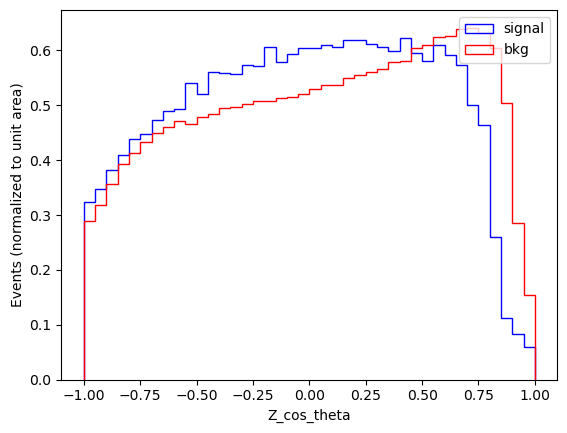

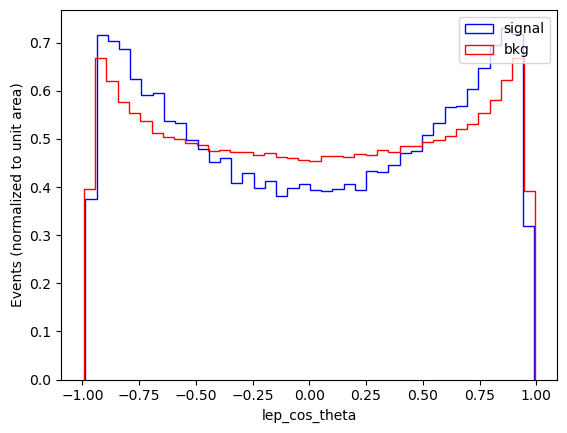

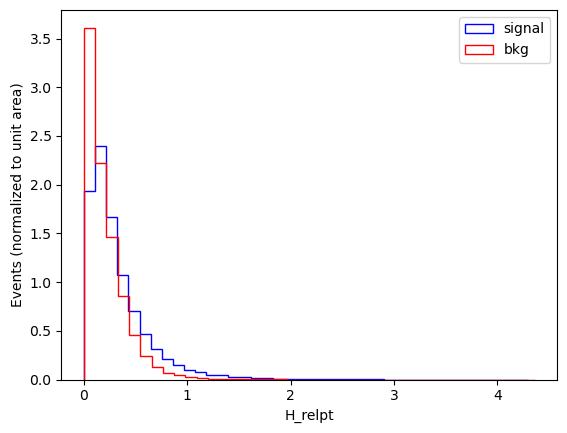

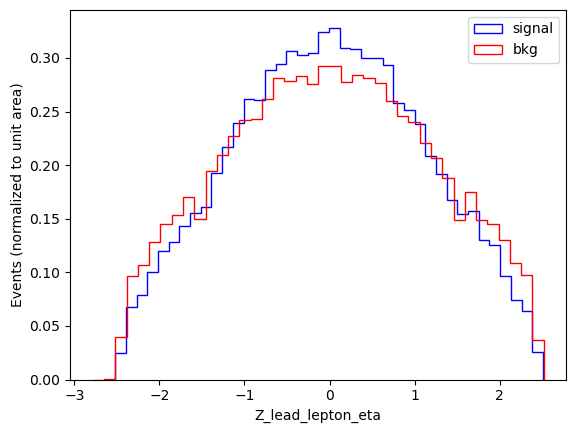

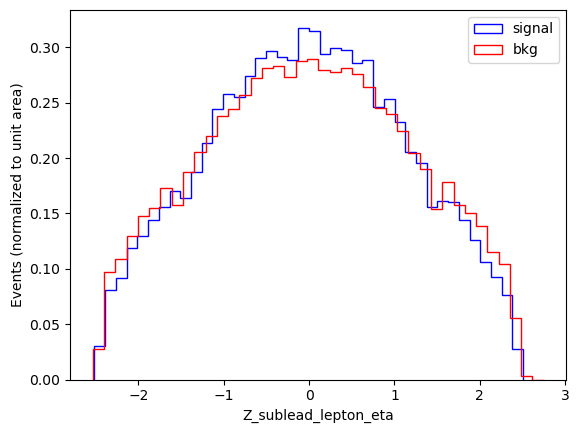

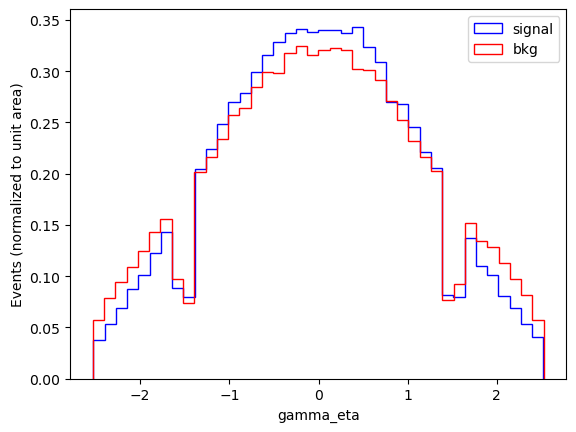

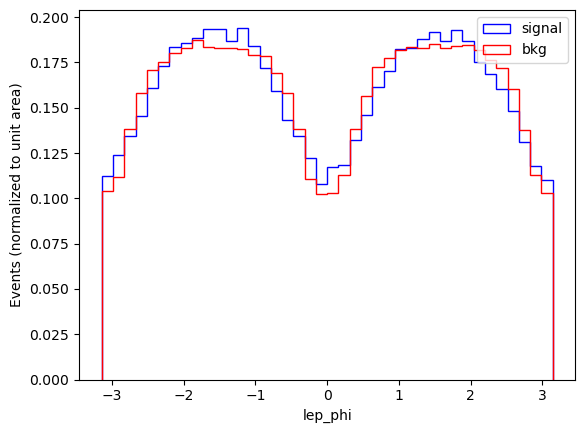

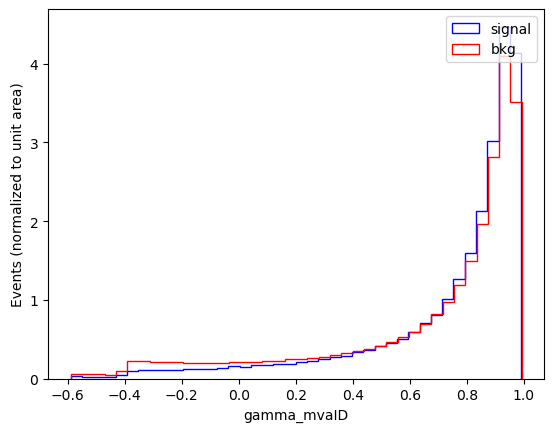

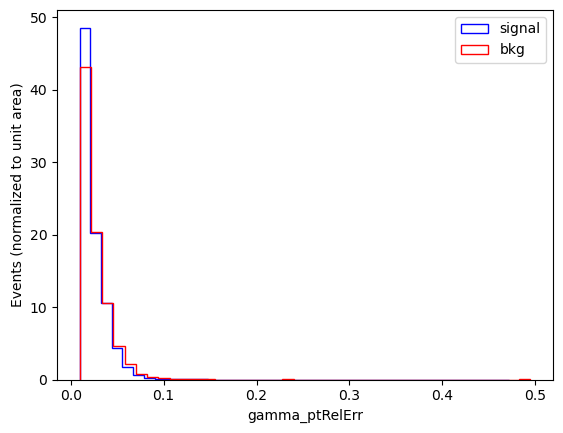

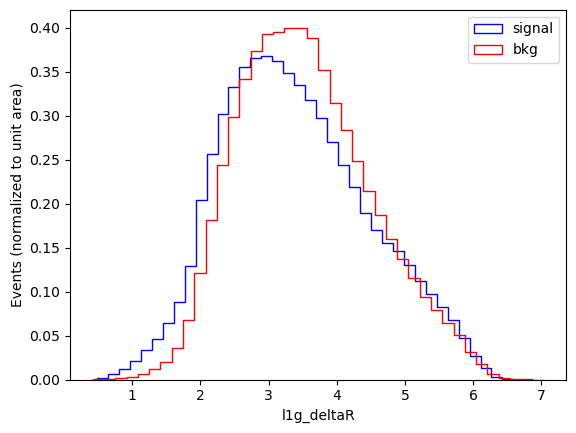

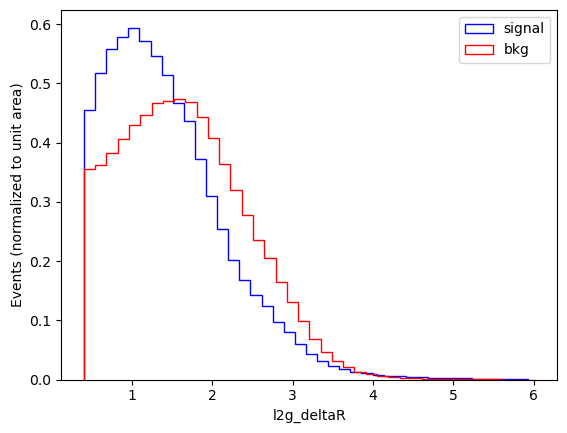

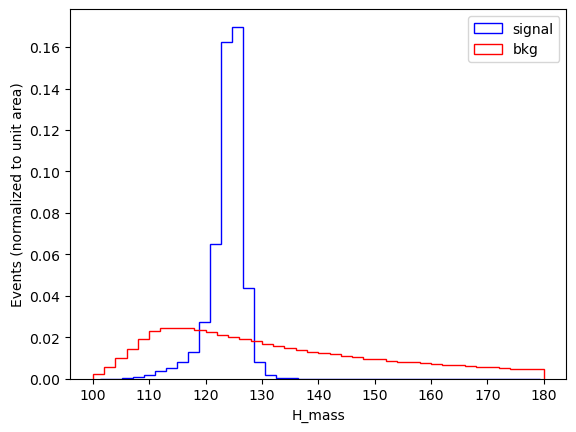

In [6]:
xlabel = ["Z_cos_theta", "lep_cos_theta", "H_relpt", "Z_lead_lepton_eta", "Z_sublead_lepton_eta", "gamma_eta", "lep_phi", "gamma_mvaID", "gamma_ptRelErr", "l1g_deltaR", "l2g_deltaR"]

for hlf,xlabel_hlf in zip(variables+mass_variables,xlabel+mass_variables):
    plt.figure()
    plt.hist(df_sig_all[hlf], bins=40, density=True, histtype='step', label='signal', color='blue')
    plt.hist(df_bkg_all[hlf], bins=40, density=True, histtype='step', label='bkg', color='red')
    #plt.hist(dfs[2][hlf], bins=40, density=True, histtype='step', label='ZG bkg', color='purple')
    #plt.hist(dfs[3][hlf], bins=40, density=True, histtype='step', label='TT bkg', color='black')
    
    plt.xlabel(xlabel_hlf)
    plt.ylabel('Events (normalized to unit area)')
    plt.legend(loc='best')

    plt.show()

['Z_cos_theta', 'lep_cos_theta', 'H_relpt', 'Z_lead_lepton_eta', 'Z_sublead_lepton_eta', 'gamma_eta', 'lep_phi', 'gamma_mvaID', 'gamma_ptRelErr', 'l1g_deltaR', 'l2g_deltaR']


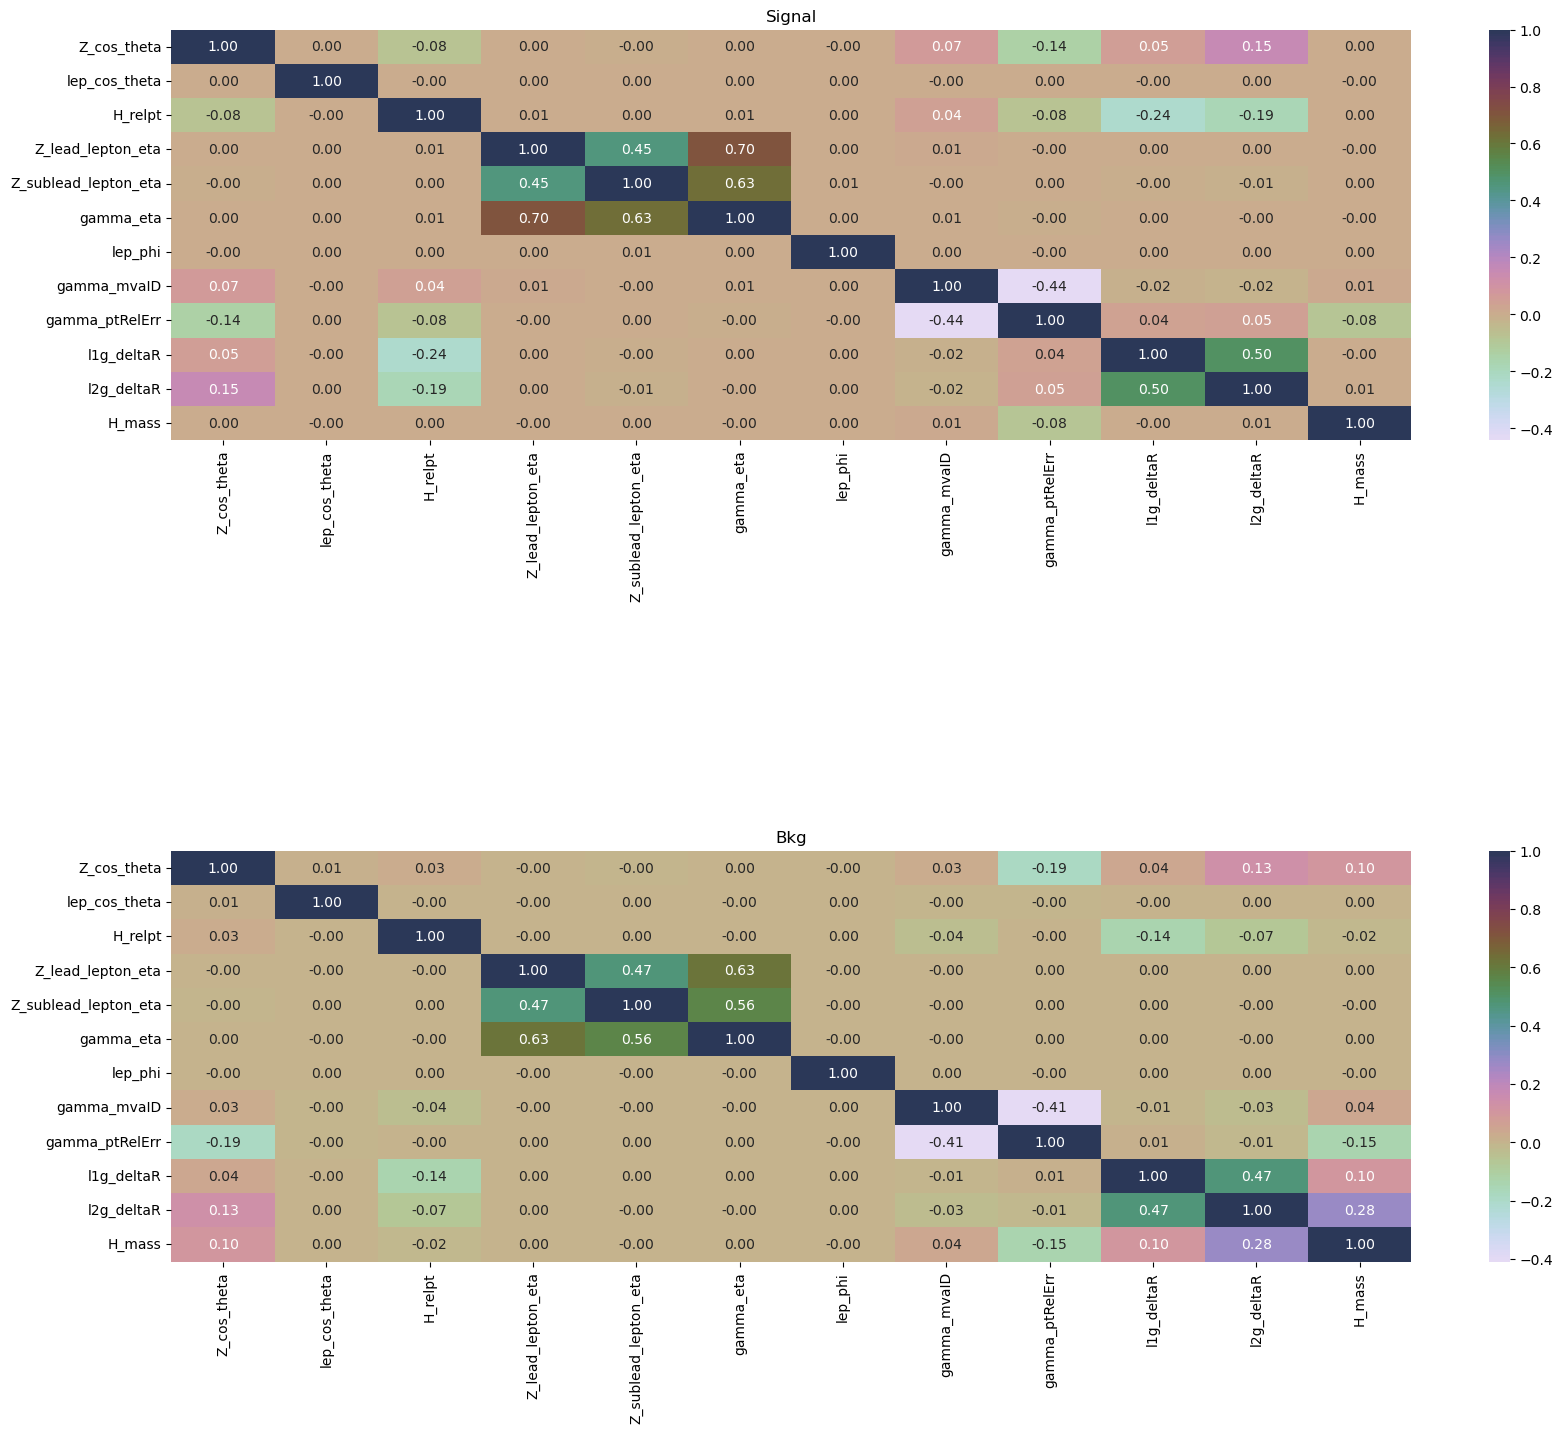

In [7]:
print(variables)

f, (ax1,ax2) = plt.subplots(figsize = (20, 16),nrows=2)
f.subplots_adjust(hspace = 1.0)
cmap = sns.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
sns.heatmap(df_sig_all[variables+mass_variables].corr(), annot=True, fmt=".2f", ax = ax1, cmap=cmap)
ax1.set_title('Signal')

sns.heatmap(df_bkg_all[variables+mass_variables].corr(), annot=True, fmt=".2f", ax = ax2, cmap=cmap)
ax2.set_title('Bkg')
f.show()
#f.savefig('./plot/corr.png')

In [7]:
var_indices = [df_sig_all.columns.get_loc(v) for v in variables] # get positions of all the variables set above
mass_var_indices = [df_sig_all.columns.get_loc(v) for v in mass_variables]
wt_var_indices = [df_sig_all.columns.get_loc(v) for v in wt_variables]

signal = df_sig_all.values
signal_ggH = df_sig_ggH.values
signal_VBF = df_sig_VBF.values
background = df_bkg_all.values
background_DY = df_bkg_dy.values
background_ZG = df_bkg_ZG.values
#background_ZG = dfs[2].values
#background_TT = dfs[3].values

print("Number of signal MC events:",len(signal))
print("Number of background MC events:",len(background))
print("Number of background DY MC events:",len(background_DY))
print("Number of background ZG MC events:",len(background_ZG))

nsigw = np.sum(signal[:,wt_var_indices])
nbkgw = np.sum(background[:,wt_var_indices])
nbkgw_DY = np.sum(background_DY[:,wt_var_indices])
nbkgw_ZG = np.sum(background_ZG[:,wt_var_indices])

print("expected number of events for signal: ")
print(nsigw)
print("expected number of events for all bkg: ")
print(nbkgw)
print("expected number of events for DY bkg: ")
print(nbkgw_DY)
print("expected number of events for ZG bkg: ")
print(nbkgw_ZG)

sig = len(signal)
bkg = len(background)
total = bkg + sig
print('Raw events:\n    Total: {}\n    Signal: {} ({:.2f}% of total)\n    Background: {} ({:.2f}% of total)\n'.format(total, sig, 100 * sig / total, bkg, 100 * bkg / total))
weight_for_0 = (1.0 / bkg)*(total)/2.0
weight_for_1 = (1.0 / sig)*(total)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}
print('Weight for class background: {:.2f}'.format(weight_for_0))
print('Weight for class signal: {:.2f}'.format(weight_for_1))
scale_weight = (1.0*bkg)/(sig*1.0)
print('scale weight : {:.2f}'.format(scale_weight))

Number of signal MC events: 84345
Number of background MC events: 619077
Number of background DY MC events: 29362
Number of background ZG MC events: 589715
expected number of events for signal: 
56.65292014555171
expected number of events for all bkg: 
130716.39684334393
expected number of events for DY bkg: 
73381.43925138252
expected number of events for ZG bkg: 
57334.957591961465
Raw events:
    Total: 703422
    Signal: 84345 (11.99% of total)
    Background: 619077 (88.01% of total)

Weight for class background: 0.57
Weight for class signal: 4.17
scale weight : 7.34


In [8]:
#signal label as 1, bkg label as 0 (ground truth)
sig_label_ggH = np.ones(len(signal_ggH))
sig_label_VBF = np.ones(len(signal_VBF))
bkg_label_DY = np.zeros(len(background_DY))
bkg_label_ZG = np.zeros(len(background_ZG))

sig_proc_ggH = -1*np.ones(len(signal_ggH))
sig_proc_VBF = -2*np.ones(len(signal_VBF))
bkg_proc_DY = np.ones(len(background_DY))
bkg_proc_ZG = 2*np.ones(len(background_ZG))

x = np.concatenate((signal_ggH, signal_VBF, background_DY, background_ZG))
y = np.concatenate((sig_label_ggH, sig_label_VBF, bkg_label_DY, bkg_label_ZG))
z = np.concatenate((sig_proc_ggH, sig_proc_VBF, bkg_proc_DY, bkg_proc_ZG))

In [9]:
# split data into train and test sets
seed = 123
test_size = 0.5
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=test_size, random_state=seed)

# For training we ignore the columns with the event ID information
x_train_reduced = x_train[:,var_indices]
x_train_w = x_train[:,wt_var_indices].flatten()
x_train_mass = x_train[:,mass_var_indices].flatten()
x_test_reduced = x_test[:,var_indices]
x_test_w = x_test[:,wt_var_indices].flatten()
x_test_mass = x_test[:,mass_var_indices].flatten()

print(x_train_reduced.shape)
print(x_train.shape)
print(len(x_train_w))
print(x[0])
print(x_train_w)

(351711, 11)
(351711, 13)
351711
[ 8.11229713e-04 -5.20858049e-01  2.80582398e-01  3.67551676e-02
  1.67480469e+00  5.35659790e-02  1.74633789e+00 -3.57052703e-01
  4.10156250e-01  4.92403125e-02  2.74653716e+00  1.81934870e+00
  1.27403198e+02]
[0.13809363 0.13809363 0.00081123 ... 0.00081123 0.00081123 0.13809363]


In [64]:
model = XGBClassifier()

# grid search parameters
depth = [3,4,5,6]
learning_rate = [0.5,0.1,0.05]
n_estimators = [500,1000,1500]
min_child_weight = [5]

param_grid = dict(learning_rate=learning_rate,max_depth=depth,n_estimators=n_estimators,min_child_weight=min_child_weight,scale_pos_weight=[scale_weight])

kflod = StratifiedKFold(n_splits=2, shuffle = True,random_state=7)

# maxmize AUC
grid_search = GridSearchCV(model,param_grid,scoring = 'roc_auc',n_jobs = -1,cv = kflod)

grid_result = grid_search.fit(x_train_reduced, y_train)

print("Best: %f using %s" % (grid_result.best_score_,grid_search.best_params_))

means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))

Best: 0.748158 using {'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 1500, 'scale_pos_weight': 7.33981860216966}
0.739217  with:   {'learning_rate': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500, 'scale_pos_weight': 7.33981860216966}
0.734071  with:   {'learning_rate': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 1000, 'scale_pos_weight': 7.33981860216966}
0.730782  with:   {'learning_rate': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 1500, 'scale_pos_weight': 7.33981860216966}
0.731164  with:   {'learning_rate': 0.5, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 500, 'scale_pos_weight': 7.33981860216966}
0.721875  with:   {'learning_rate': 0.5, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 1000, 'scale_pos_weight': 7.33981860216966}
0.716947  with:   {'learning_rate': 0.5, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 1500, 'scale_pos_weight': 7.33981860216966}
0.720725  with:   

In [11]:
model_file = 'model_HZGamma_BDT_param.pkl'

#XGBClassifier/BDT model parameters
#https://xgboost.readthedocs.io/en/latest/python/python_api.html

depth_best=4
learning_rate_best=0.1
n_estimators_best=200
min_child_weight_best=5


# fit model no training sample
model_best = XGBClassifier(
    max_depth=depth_best,
    learning_rate=learning_rate_best,
    n_estimators=n_estimators_best,
    min_child_weight=min_child_weight_best,
    scale_pos_weight=scale_weight,
    early_stopping_rounds=10,
    eval_metric=["logloss","error"],
    base_score=0.5,
    booster='gbtree',
    colsample_bylevel=1,
    colsample_bynode=1, 
    colsample_bytree=1, 
    gamma=0,
    max_delta_step=0,
    objective='binary:logistic', 
    random_state=0, 
    reg_alpha=0,
    reg_lambda=1,
    subsample=1, 
    verbosity=1)
print(model_best)

# do cross validation
#xgtrain = xgb.DMatrix(x_train_reduced, label=y_train)

#xgb_param = model_best.get_xgb_params()
#cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=5000, nfold=5, metrics=['auc'],early_stopping_rounds=50, stratified=True, seed=1301)
#print('Best number of trees = {}'.format(cvresult.shape[0]))
#print(cvresult)

#model_best.set_params(n_estimators=cvresult.shape[0])


#early_stopping_rounds (int): Activates early stopping. Validation metric needs to improve at least once in every early_stopping_rounds round(s) to continue training.
eval_set = [(x_train_reduced, y_train), (x_test_reduced, y_test)]
model_best.fit(x_train_reduced, y_train,eval_set=eval_set,verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              device=None, early_stopping_rounds=10, enable_categorical=False,
              eval_metric=['logloss', 'error'], feature_types=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=4, max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=0, ...)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              device=None, early_stopping_rounds=10, enable_categorical=False,
              eval_metric=['logloss', 'error'], feature_types=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=4, max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=0, ...)

In [12]:
print("save model file ",model_file)
output = open(model_file, 'wb')
pickle.dump(model_best, output)
output.close()

save model file  model_HZGamma_BDT_param.pkl


In [10]:
# Read in model saved from previous running of BDT
model_file = 'model_HZGamma_BDT_param.pkl'
filename=model_file
# load the model from disk
model = pickle.load(open(filename, 'rb'))

3.501152734515803e-10
0.060740664722261695
KstestResult(statistic=0.02307160044375145, pvalue=3.501152734515803e-10)
Anderson_ksampResult(statistic=38.35414842261292, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)
MannwhitneyuResult(statistic=914723254.0, pvalue=5.840234153775833e-13)
42046
309665
Ttest_indResult(statistic=8.47952177578701, pvalue=2.2970847204708768e-17)


/tmp/ipykernel_17262/1210154751.py:34: UserWarning: p-value floored: true value smaller than 0.001
  print(stats.anderson_ksamp([disc_train_signal_all,disc_test_signal_all]))


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              device=None, early_stopping_rounds=10, enable_categorical=False,
              eval_metric=['logloss', 'error'], feature_types=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=4, max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=0, ...)
(351711, 11)
(351711, 11)


/publicfs/cms/user/wangzebing/anaconda/anaconda3/envs/hzgenv/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


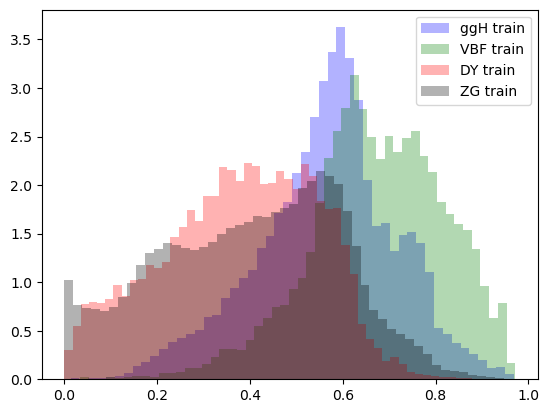

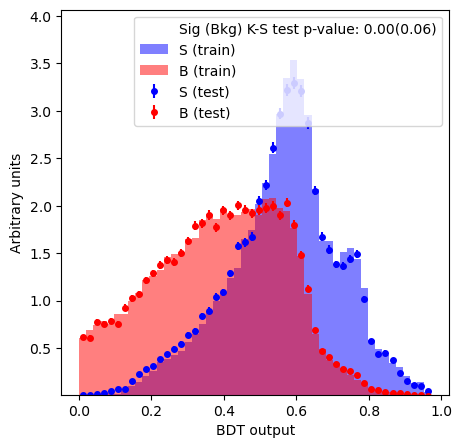

In [11]:
#make predictions for test sample
y_test_pred = model.predict_proba(x_test_reduced)[:, 1]
y_train_pred = model.predict_proba(x_train_reduced)[:, 1]

##########################################################
# make histogram of discriminator value for signal and bkg
##########################################################

y_test_frame = pd.DataFrame({'truth':z_test, 'disc':y_test_pred, 'label':y_test, 'weight':x_test_w, 'H_mass':x_test_mass})
y_train_frame = pd.DataFrame({'truth':z_train, 'disc':y_train_pred, 'label':y_train, 'weight':x_train_w, 'H_mass':x_train_mass})

disc_train_bkg_DY = y_train_frame[y_train_frame['truth'] == 1]['disc'].values
disc_train_bkg_ZG = y_train_frame[y_train_frame['truth'] == 2]['disc'].values
disc_train_signal_ggH = y_train_frame[y_train_frame['truth'] == -1]['disc'].values
disc_train_signal_VBF = y_train_frame[y_train_frame['truth'] == -2]['disc'].values
disc_train_bkg_all = y_train_frame[y_train_frame['truth'] > 0]['disc'].values
disc_train_signal_all = y_train_frame[y_train_frame['truth'] < 0]['disc'].values

disc_test_bkg_DY = y_test_frame[y_test_frame['truth'] == 1]['disc'].values
disc_test_bkg_ZG = y_test_frame[y_test_frame['truth'] == 2]['disc'].values
disc_test_signal_ggH = y_test_frame[y_test_frame['truth'] == -1]['disc'].values
disc_test_signal_VBF = y_test_frame[y_test_frame['truth'] == -2]['disc'].values
disc_test_bkg_all = y_test_frame[y_test_frame['truth'] > 0]['disc'].values
disc_test_signal_all = y_test_frame[y_test_frame['truth'] < 0]['disc'].values


# K-S test
stat_signal,pval_signal = ks_2samp(disc_train_signal_all,disc_test_signal_all)
#stat_signal,pval_signal = ks_2samp(disc_train_signal_all[disc_train_signal_all>0.5],disc_test_signal_all[disc_test_signal_all>0.5])
stat_bkg,pval_bkg = ks_2samp(disc_train_bkg_all,disc_test_bkg_all)
print(pval_signal)
print(pval_bkg)
print(ks_2samp(disc_train_signal_all*100.0,disc_test_signal_all*100.0))
print(stats.anderson_ksamp([disc_train_signal_all,disc_test_signal_all]))
print(stats.mannwhitneyu(disc_train_signal_all,disc_test_signal_all,alternative='two-sided',use_continuity = False))
print(len(disc_train_signal_all))
print(len(disc_train_bkg_all))
print(stats.ttest_ind(disc_train_signal_all,disc_test_signal_all))

bins = 50

plt.figure()
#plt.hist(disc_train_bkg_all, density=True, bins=bins, alpha=0.3, label='bkg train', color='red',weights=y_train_frame[y_train_frame['truth'] > 0]['weight'])
#plt.hist(disc_train_signal_all, density=True, bins=bins, alpha=0.3, label='signal train', color='blue',weights=y_train_frame[y_train_frame['truth'] < 0]['weight'])
plt.hist(disc_train_signal_ggH, density=True, bins=bins, alpha=0.3, label='ggH train', color='blue',weights=y_train_frame[y_train_frame['truth'] == -1]['weight'])
plt.hist(disc_train_signal_VBF, density=True, bins=bins, alpha=0.3, label='VBF train', color='green',weights=y_train_frame[y_train_frame['truth'] == -2]['weight'])
plt.hist(disc_train_bkg_DY, density=True, bins=bins, alpha=0.3, label='DY train', color='red',weights=y_train_frame[y_train_frame['truth'] == 1]['weight'])
plt.hist(disc_train_bkg_ZG, density=True, bins=bins, alpha=0.3, label='ZG train', color='black',weights=y_train_frame[y_train_frame['truth'] == 2]['weight'])


#plt.scatter(x_values, y_values, s=100) 

#plt.hist(disc_test_bkg_all, normed=True, bins=50, alpha=0.3, label='DY bkg test', color='red')
#plt.hist(disc_test_signal, normed=True, bins=50, alpha=0.3, label='signal test', color='blue')
plt.legend(loc='best')

compare_train_test(model,x_train_reduced,y_train,z_train,x_train_w,x_test_reduced,y_test,z_test,x_test_w,bins=bins)

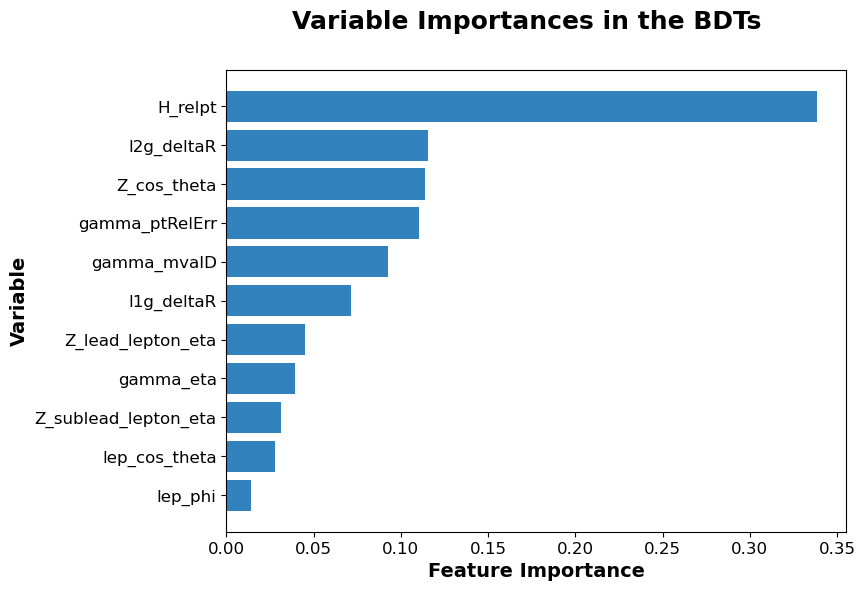

In [12]:
##########################################################
# Rank training variable of importance
##########################################################
# sort variables by feature importance
sorted_idx = model.feature_importances_.argsort()
#variables = variables + ['param']
#variables_label = variables_label
variables_sorted = [xlabel[i] for i in sorted_idx]

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(variables_sorted, model.feature_importances_[sorted_idx], color='#3182bd')

# Add axis labels and increase font size
ax.set_xlabel('Feature Importance', fontsize=14, fontweight='bold')
ax.set_ylabel('Variable', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add title and caption
fig.suptitle('Variable Importances in the BDTs', fontsize=18, fontweight='bold')
#fig.text(0.5, 0.05, 'Source: Your data analysis', ha='center', fontsize=10, color='gray')

# Save and show the plot
#plt.savefig('./plot/rank.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
#subset_dy_vbf = y_test_frame.loc[(y_test_frame['label'] !=1 ) | (y_test_frame['label'] ==1)] 
#subset_train_dy_vbf = y_train_frame.loc[(y_train_frame['label'] !=1 ) | (y_train_frame['label'] ==1)] 
#en(y_test_frame['label'])
y_test_frame['disc']

0         0.769405
1         0.628210
2         0.543542
3         0.382503
4         0.084558
            ...   
351706    0.702990
351707    0.734871
351708    0.684352
351709    0.208626
351710    0.521503
Name: disc, Length: 351711, dtype: float32

test K-S value:  0.3374946274887846
train K-S value:  0.3593001358517114


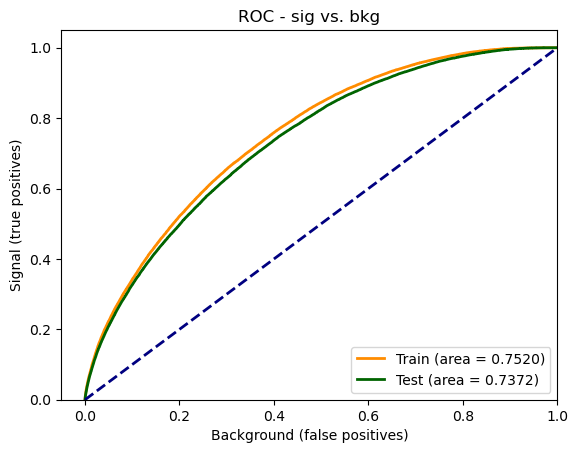

In [13]:
##########################################################
# make ROC curve
##########################################################

#get roc curve
#fpr, tpr, _ = roc_curve(y_test, y_pred, x_test_w)

fpr_test, tpr_test, _ = roc_curve(y_test_frame['label'].values, y_test_frame['disc'].values)
fpr_train, tpr_train, _ = roc_curve(y_train_frame['label'].values, y_train_frame['disc'].values)

ks_test = max(tpr_test-fpr_test)
auc_test = auc(fpr_test,tpr_test)
print("test K-S value: ",ks_test)

ks_train = max(tpr_train-fpr_train)
auc_train = auc(fpr_train,tpr_train)
print("train K-S value: ",ks_train)

#plot roc curve
plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw, label=r'Train (area = {0:.4f})'.format(auc_train))

plt.plot(fpr_test, tpr_test, color='darkgreen',
         lw=lw, label=r'Test (area = {0:.4f})'.format(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background (false positives)')
plt.ylabel('Signal (true positives)')
plt.title(r'ROC - sig vs. bkg')
plt.legend(loc="lower right")
#plt.savefig('./plot/ROC.png')

# Start BDT Optimization

In [117]:
from ROOT import *
from array import array

In [19]:

data_all_reduced = df_data_all.to_numpy()[:,var_indices]
data_all_w = df_data_all.to_numpy()[:,wt_var_indices].flatten()
data_all_mass = df_data_all.to_numpy()[:,mass_var_indices].flatten()
data_all_pred = model.predict_proba(data_all_reduced)[:, 1]

data_all_frame = pd.DataFrame({'truth':None, 'disc':data_all_pred, 'label':None, 'weight':data_all_w, 'H_mass':data_all_mass})

data_SB = data_all_frame[( (data_all_frame["H_mass"] > 100) & (data_all_frame["H_mass"] < 120) ) | ( (data_all_frame["H_mass"] > 130) & (data_all_frame["H_mass"] < 180) )]
data_SR = data_all_frame[( (data_all_frame["H_mass"] > 120) & (data_all_frame["H_mass"] < 130) )]

# reweight test dataset for the optimization
reweight = 1.0/test_size
y_test_frame["weight"] = y_test_frame["weight"]*reweight

bkg_SB = y_test_frame[ (( (y_test_frame["H_mass"] > 100) & (y_test_frame["H_mass"] < 120) ) | ( (y_test_frame["H_mass"] > 130) & (y_test_frame["H_mass"] < 180) )) & (y_test_frame['truth'] > 0)]
bkg_SR = y_test_frame[(( (y_test_frame["H_mass"] > 120) & (y_test_frame["H_mass"] < 130) )) & (y_test_frame['truth'] > 0)]

sig_SB = y_test_frame[ (( (y_test_frame["H_mass"] > 100) & (y_test_frame["H_mass"] < 120) ) | ( (y_test_frame["H_mass"] > 130) & (y_test_frame["H_mass"] < 180) )) & (y_test_frame['truth'] < 0)]
sig_SR = y_test_frame[(( (y_test_frame["H_mass"] > 120) & (y_test_frame["H_mass"] < 130) )) & (y_test_frame['truth'] < 0)]

In [95]:


def draw_dataMC(var_name, nbins = 50,range=(0,1)):
    #var_name = 'disc'
    hist_DY, bins = np.histogram(y_test_frame[var_name][y_test_frame['truth']==1], weights=y_test_frame['weight'][y_test_frame['truth']==1], bins=nbins,range=range)
    hist_ZG, _ = np.histogram(y_test_frame[var_name][y_test_frame['truth']==2], weights=y_test_frame['weight'][y_test_frame['truth']==2], bins=nbins,range=range)
    #data_mass_blind = data_all_frame['H_mass'].loc[(data_all_frame['H_mass'] >= 120), 'H_mass'] = 0
    hist_data, _ = np.histogram(data_all_frame[var_name], bins=nbins,range=range)
    hist_data_err = np.sqrt(hist_data)
    center = (bins[:-1] + bins[1:]) / 2


    # 绘制堆叠的直方图
    plt.bar(bins[:-1], hist_DY, width=np.diff(bins), label='DY')
    plt.bar(bins[:-1], hist_ZG, width=np.diff(bins), label='ZG', bottom=hist_DY)
    plt.hist(y_test_frame[var_name][y_test_frame['truth']<0], weights=y_test_frame['weight'][y_test_frame['truth']<0]*50, bins=bins, histtype='step', color='r', label='Signal * 50')
    plt.errorbar(center, hist_data, yerr=hist_data_err, fmt='.', c='black', label='data', markersize=8,capthick=0)

    plt.legend()
    plt.xlabel(var_name)
    plt.ylabel('Weighted Frequency')
    plt.title('Stacked Weighted Histogram of Mass by Truth')
    plt.show()

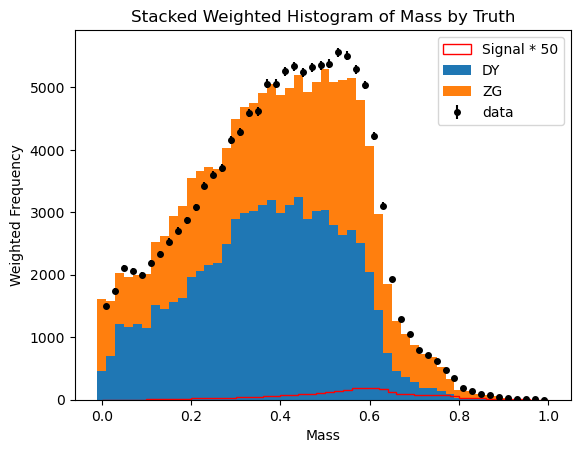

In [96]:
draw_dataMC(var_name='disc',nbins = 50,range=(0,1))

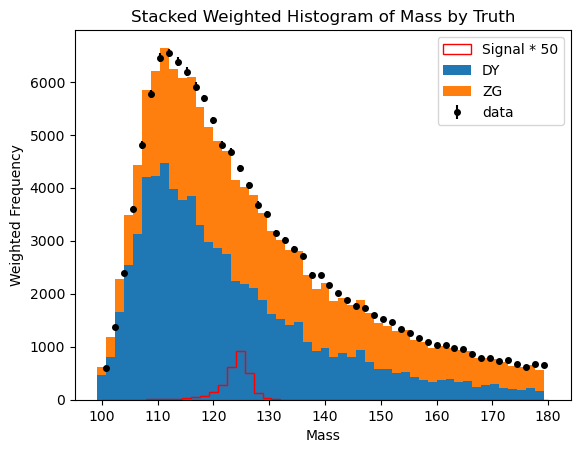

In [97]:
draw_dataMC(var_name='H_mass',nbins = 50, range=(100,180))

In [190]:
nbins = 200
hist_bkg_SB, bins = np.histogram(bkg_SB['disc'], weights=bkg_SB['weight'], bins=nbins,range=(0,1))
hist_bkg_SR, bins = np.histogram(bkg_SR['disc'], weights=bkg_SR['weight'], bins=nbins,range=(0,1))
hist_sig_SR, bins = np.histogram(sig_SR['disc'], weights=sig_SR['weight'], bins=nbins,range=(0,1))
hist_data_SB, bins = np.histogram(data_SB['disc'], weights=data_SB['weight'], bins=nbins,range=(0,1))

In [200]:
def SetgStyle():

    gStyle.SetFrameFillColor(0)
    gStyle.SetStatColor(0)
    gStyle.SetOptStat(0)
    gStyle.SetTitleFillColor(0)
    gStyle.SetCanvasBorderMode(0)
    gStyle.SetPadBorderMode(0)
    gStyle.SetFrameBorderMode(0)
    gStyle.SetPadColor(kWhite)
    gStyle.SetCanvasColor(kWhite)
    
    
    gStyle.SetCanvasDefH(600) #Height of canvas
    gStyle.SetCanvasDefW(600) #Width of canvas
    gStyle.SetCanvasDefX(0)   #POsition on screen
    gStyle.SetCanvasDefY(0)

    
    gStyle.SetPadLeftMargin(0.13)
    gStyle.SetPadRightMargin(0.05)
    gStyle.SetPadTopMargin(0.085)
    gStyle.SetPadBottomMargin(0.12)
    
    # For hgg axis titles:
    gStyle.SetTitleColor(1, "XYZ")
    gStyle.SetTitleFont(42, "XYZ")
    gStyle.SetTitleSize(0.04, "XYZ")
    gStyle.SetTitleXOffset(0.95)#//0.9)
    gStyle.SetTitleYOffset(1.15)# // => 1.15 if exponents
    
    # For hgg axis labels:
    gStyle.SetLabelColor(1, "XYZ")
    gStyle.SetLabelFont(42, "XYZ")
    gStyle.SetLabelOffset(0.007, "XYZ")
    gStyle.SetLabelSize(0.04, "XYZ")
    
    # Legends
    gStyle.SetLegendBorderSize(0)
    gStyle.SetLegendFillColor(kWhite)
    gStyle.SetLegendFont(42)
    
    gStyle.SetFillColor(10)
    # Nothing for now
    gStyle.SetTextFont(42)
    gStyle.SetTextSize(0.03)

def trans2rootHist(hist, bins, name):
    hist_root = TH1D(name, name, len(bins) - 1, bins)

    for i in range(len(hist)):
        hist_root.SetBinContent(i + 1, hist[i])

    return hist_root

def hist2graph(hist, mva_low = 0.1):
    
    Nbins = hist.GetNbinsX()
    bin_x_low = hist.FindBin(mva_low)
    xaxis = hist.GetXaxis()

    bin_x_Center=[]
    bin_y=[]
    for x in range(Nbins+1):
        # remove BDT score less than mva_low
        if x < bin_x_low: continue
        bin_x_Center.append(xaxis.GetBinCenter(x))
        bin_y.append(hist.GetBinContent(x))

    graph = TGraph(Nbins-bin_x_low+1, np.array(bin_x_Center), np.array(bin_y))

    return graph

def smooth(graph, hist, mva_low = 0.1):
    h_smooth = TH1F(hist.GetName()+"_smooth",hist.GetName()+"_smooth",hist.GetNbinsX(),0.0,1.0)
    h_smooth_up = TH1F(hist.GetName()+"_smooth_up",hist.GetName()+"_smooth_up",hist.GetNbinsX(),0.0,1.0)
    h_smooth_dn = TH1F(hist.GetName()+"_smooth_dn",hist.GetName()+"_smooth_dn",hist.GetNbinsX(),0.0,1.0)

    smoother = TGraphSmooth()
    g_smooth = smoother.SmoothSuper(graph)

    xaxis = hist.GetXaxis()
    x = array('d', [0])
    y = array('d', [0])

    for i in range(1, hist.GetNbinsX()+1):

        h_x = xaxis.GetBinCenter(i)

        if i < hist.FindBin(mva_low):
            y[0] = 0.0
        else:
            g_smooth.GetPoint(i,x,y)

        h_smooth.SetBinContent(i,y[0])

    for i in range(1, hist.GetNbinsX()+1):

        if i < hist.FindBin(mva_low):
            y[0] = 0.0
        else:
            y[0] = h_smooth.GetBinContent(i)

        #print(y)
        #print(y[0])
        #print np.sqrt(y)

        if y[0]>=0.:
            h_smooth_up.SetBinContent(i,y+np.sqrt(y))
            if (y-np.sqrt(y))>0.: h_smooth_dn.SetBinContent(i,y-np.sqrt(y))
            else: h_smooth_dn.SetBinContent(i,0.)
        else:
            h_smooth_up.SetBinContent(i,0.)
            h_smooth_dn.SetBinContent(i,0.)


            

    return [h_smooth, h_smooth_up, h_smooth_dn]

def GetHist(hist):
    
    graph = hist2graph(hist, 0.)
    hist_smooth = smooth(graph, hist, 0.)

    return hist, hist_smooth

def compare(hist, hist_smooth):
    canv = TCanvas("cc", "cc", 650, 600)
    canv.cd()
    #canv.SetLogy()
    SetgStyle()
    '''
    canv.SetRightMargin(0.1)
    canv.SetLeftMargin(0.13)
    canv.SetTopMargin(0.085)
    canv.SetBottomMargin(0.12)
    '''

    #hist.SetMinimum(1e-1)
    #hist.SetMaximum(1e2)
    #hist_smooth[0].SetMinimum(1e-1)
    #hist_smooth[0].SetMaximum(1e4)

    hist.SetFillColor(10)
    hist.SetLineColor(kBlack)
    hist.GetXaxis().SetTitle('BDT Output')
    hist.GetYaxis().SetTitle('Events')

    hist.GetYaxis().SetLabelSize(0.04)
    hist.GetYaxis().SetLabelColor(1)
    hist.GetYaxis().SetLabelFont(42)
    hist.GetYaxis().SetLabelOffset(0.007)
    hist.GetYaxis().SetTitleColor(1)
    hist.GetYaxis().SetTitleFont(42)
    hist.GetYaxis().SetTitleSize(0.05)

    hist.GetXaxis().SetLabelSize(0.04)
    hist.GetXaxis().SetLabelColor(1)
    hist.GetXaxis().SetLabelFont(42)
    hist.GetXaxis().SetLabelOffset(0.007)
    hist.GetXaxis().SetTitleColor(1)
    hist.GetXaxis().SetTitleFont(42)
    hist.GetXaxis().SetTitleSize(0.05)


    hist.Draw("HIST")



    hist_smooth[1].SetLineColor(kGreen)
    hist_smooth[1].SetLineWidth(2)
    hist_smooth[1].Draw("SAME")

    hist_smooth[2].SetLineColor(kBlue)
    hist_smooth[2].SetLineWidth(2)
    hist_smooth[2].Draw("SAME")

    hist_smooth[0].SetLineColor(kRed)
    hist_smooth[0].SetLineWidth(2)
    hist_smooth[0].Draw("SAME")

    #canv.cd()
    global legend
    legend = TLegend(0.6,0.65,0.88,0.88)
    #legend.AddEntry(hist, "Background")
    legend.AddEntry(hist_smooth[1], "Smoothing + 1#sigma", "l")
    legend.AddEntry(hist_smooth[0], "Smoothing", "l")
    legend.AddEntry(hist_smooth[2], "Smoothing - 1#sigma", "l")
    legend.Draw("SAME")

    latex = TLatex()
    latex.SetNDC()
    latex.SetTextColor(kBlack)
    latex.SetTextFont(42)
    latex.SetTextSize(0.042)
    latex.SetTextAlign(31)


    canv.Update()
    #print legend

    #cmsText     = "CMS";
    #cmsTextFont   = 61
    #latex = rt.TLatex()

    

    return canv

def computeSignificance(s,b,d_noSmooth):
    significance = -999.
    if b>0 and s>0.: significance = (2*(s+b)*math.log(1+(s/b))) - 2*s
    if significance>0. and d_noSmooth>=10. and b>0.: return np.sqrt((2*(s+b)*math.log(1+(s/b))) - 2*s)
    else: return -999.

def sumSignificance(partition, h_sig_SR, h_bkg_SR,h_data_SB_noSmooth):
    sum = 0.
    for pair in partition:
        s = h_sig_SR.Integral(pair[0],pair[1])
        b = h_bkg_SR.Integral(pair[0],pair[1])
        d_noSmooth = h_data_SB_noSmooth.Integral(pair[0],pair[1])
        significance = computeSignificance(s,b,d_noSmooth)
        #print h_sig_SR.GetBinCenter(pair[0])-h_bdt_signal_SR.GetBinWidth(pair[0])/2.,significance,b
        if significance>0.: sum += significance*significance
        else: return -999.
    return np.sqrt(sum)

def getResults(h_bdt_signal_SR, h_bdt_datamix_SR_weighted_smooth, h_bdt_data_SB, nCats, nBins):

    significance_final = -999.
    partition_final = []
    sig_all = {}

    #1 categories
    if nCats == 1:

        for i in range(1,nBins+1):
            partition = [[i,nBins]]
            significance = sumSignificance(partition, h_bdt_signal_SR, h_bdt_datamix_SR_weighted_smooth, h_bdt_data_SB)
            #print h_bdt_signal_SR.GetBinCenter(partition[0][0])-h_bdt_signal_SR.GetBinWidth(partition[0][0])/2,"1. --->",significance,h_bdt_data_SB.Integral(partition[0][0],nBins)
            #print h_bdt_signal_SR.GetBinCenter(partition[0][0])-h_bdt_signal_SR.GetBinWidth(partition[0][0])/2,"1. --->",significance
            if significance>significance_final:
                significance_final = significance
                partition_final = partition
            sig_all[i] = significance
        output = nCats," - Best category: ",h_bdt_signal_SR.GetBinCenter(partition_final[0][0])-h_bdt_signal_SR.GetBinWidth(partition_final[0][0])/2,"1. --->",significance_final,"signal total: ",h_bdt_signal_SR.Integral(1,nBins+1),"events:",h_bdt_signal_SR.GetEntries(),"signal cut",h_bdt_signal_SR.Integral(partition_final[0][0],nBins),"smoothed background: ",h_bdt_datamix_SR_weighted_smooth.Integral(partition_final[0][0],nBins),"data: ",h_bdt_data_SB.Integral(partition_final[0][0],nBins),"NEXT BIN: ","smoothed background: ",h_bdt_datamix_SR_weighted_smooth.Integral(partition_final[0][0]+1,nBins),"data: ",h_bdt_data_SB.Integral(partition_final[0][0]+1,nBins)
        print(' '.join(map(str,output)))

    #2 categories
    elif nCats == 2:

        for i in range(1,nBins+1):
            for j in range(i+1,nBins+1):
                partition = [[1,i],[j,nBins]]
                if abs(i-j)==1:
                    #print partition
                    significance = sumSignificance(partition, h_bdt_signal_SR, h_bdt_datamix_SR_weighted_smooth, h_bdt_data_SB)
                    if significance>significance_final:
                        significance_final = significance
                        partition_final = partition
                
        output = nCats," - Best categories: ",h_bdt_signal_SR.GetBinCenter(partition_final[0][0])-h_bdt_signal_SR.GetBinWidth(partition_final[0][0])/2,h_bdt_signal_SR.GetBinCenter(partition_final[1][0])-h_bdt_signal_SR.GetBinWidth(partition_final[1][0])/2,"1. --->",significance_final
        print(' '.join(map(str,output)))

    #3 categories
    elif nCats == 3:

        for i in range(1,nBins+1):
            for j in range(i+1,nBins+1):
                for k in range(j+1,nBins+1):
                    partition = [[1,i],[j,k-1],[k,nBins]]
                    if abs(i-j)==1:
                        #print partition
                        significance = sumSignificance(partition, h_bdt_signal_SR, h_bdt_datamix_SR_weighted_smooth, h_bdt_data_SB)
                        if significance>significance_final:
                            significance_final = significance
                            partition_final = partition

        output = nCats," - Best categories: ",h_bdt_signal_SR.GetBinCenter(partition_final[0][0])-h_bdt_signal_SR.GetBinWidth(partition_final[0][0])/2, h_bdt_signal_SR.GetBinCenter(partition_final[1][0])-h_bdt_signal_SR.GetBinWidth(partition_final[1][0])/2, h_bdt_signal_SR.GetBinCenter(partition_final[2][0])-h_bdt_signal_SR.GetBinWidth(partition_final[2][0])/2, "1. --->",significance_final
        print(' '.join(map(str,output)))

    #4 categories
    elif nCats == 4:

        for i in range(1,nBins+1):
            for j in range(i+1,nBins+1):
                for k in range(j+1,nBins+1):
                    for d in range(k+1,nBins+1):
                        partition = [[1,i],[j,k-1],[k,d-1],[d,nBins]]
                        if abs(i-j)==1:
                            #print partition
                            significance = sumSignificance(partition, h_bdt_signal_SR, h_bdt_datamix_SR_weighted_smooth, h_bdt_data_SB)
                            if significance>significance_final:
                                significance_final = significance
                                partition_final = partition

        output = nCats," - Best categories: ",h_bdt_signal_SR.GetBinCenter(partition_final[0][0])-h_bdt_signal_SR.GetBinWidth(partition_final[0][0])/2, h_bdt_signal_SR.GetBinCenter(partition_final[1][0])-h_bdt_signal_SR.GetBinWidth(partition_final[1][0])/2, h_bdt_signal_SR.GetBinCenter(partition_final[2][0])-h_bdt_signal_SR.GetBinWidth(partition_final[2][0])/2, h_bdt_signal_SR.GetBinCenter(partition_final[3][0])-h_bdt_signal_SR.GetBinWidth(partition_final[3][0])/2, "1. --->",significance_final
        print(' '.join(map(str,output)))

    #5 categories
    elif nCats == 5:
        for i in range(1,nBins+1):
            for j in range(i+1,nBins+1):
                for k in range(j+1,nBins+1):
                    for d in range(k+1,nBins+1):
                        for f in range(d+1,nBins+1):
                            partition = [[1,i],[j,k-1],[k,d-1],[d,f-1],[f,nBins]]
                            if abs(i-j)==1:
                            #print partition
                                significance = sumSignificance(partition, h_bdt_signal_SR, h_bdt_datamix_SR_weighted_smooth, h_bdt_data_SB)
                                if significance>significance_final:
                                    significance_final = significance
                                    partition_final = partition

        output = nCats," - Best categories: ",h_bdt_signal_SR.GetBinCenter(partition_final[0][0])-h_bdt_signal_SR.GetBinWidth(partition_final[0][0])/2, h_bdt_signal_SR.GetBinCenter(partition_final[1][0])-h_bdt_signal_SR.GetBinWidth(partition_final[1][0])/2, h_bdt_signal_SR.GetBinCenter(partition_final[2][0])-h_bdt_signal_SR.GetBinWidth(partition_final[2][0])/2, h_bdt_signal_SR.GetBinCenter(partition_final[3][0])-h_bdt_signal_SR.GetBinWidth(partition_final[3][0])/2, h_bdt_signal_SR.GetBinCenter(partition_final[4][0])-h_bdt_signal_SR.GetBinWidth(partition_final[4][0])/2, "1. --->",significance_final
        print(' '.join(map(str,output)))

    else:
        print("Number of categories not supported, choose: 1, 2, 3, 4, 5, 6, 7, 8 or 9!")
        sys.exit()

    
    return partition_final, significance_final, output, sig_all

In [201]:
roohist_bkg_SB = trans2rootHist(hist_bkg_SB, bins, "bkg_SB")
roohist_bkg_SR = trans2rootHist(hist_bkg_SR, bins, "bkg_SR")
roohist_sig_SR = trans2rootHist(hist_sig_SR, bins, "sig_SR")
roohist_data_SB = trans2rootHist(hist_data_SB, bins, "data_SR")


Warning in <TROOT::Append>: Replacing existing TH1: bkg_SB (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: bkg_SR (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: sig_SR (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data_SR (Potential memory leak).


Warning in <TROOT::Append>: Replacing existing TH1: bkg_SR_smooth (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: bkg_SR_smooth_up (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: bkg_SR_smooth_dn (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data_SR_smooth (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data_SR_smooth_up (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data_SR_smooth_dn (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc


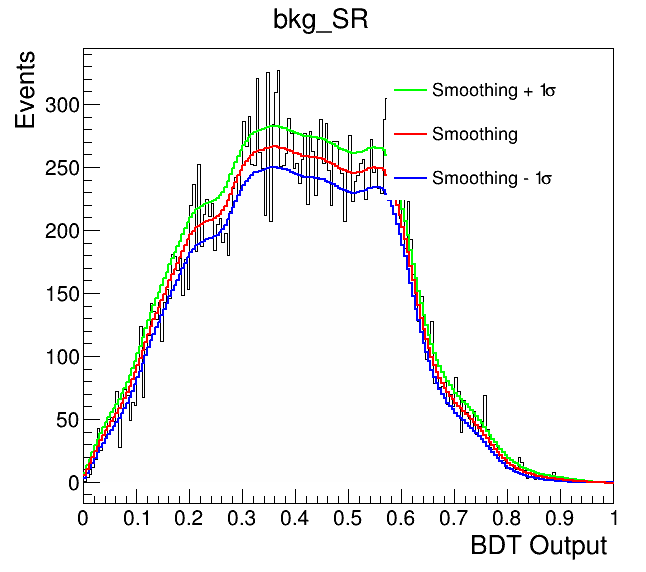

In [202]:
hist_SR, hist_SR_smooth = GetHist(roohist_bkg_SR)
hist_CR, hist_CR_smooth = GetHist(roohist_data_SB)
canv_SR = compare(hist_SR, hist_SR_smooth)
canv_SR.Draw()

In [203]:
nCats = 5
partition_final = {}
significance_final = {}
output = {}
significance_all = {}

partition_final_up = {}
significance_final_up = {}
output_up = {}
significance_all_up = {}
partition_final_dn = {}
significance_final_dn = {}
output_dn = {}
significance_all_dn = {}


partition_final, significance_final, output, significance_all = getResults(roohist_sig_SR, hist_SR_smooth[0], hist_CR, nCats, nbins)
#partition_final_up, significance_final_up, output_up, significance_all_up = getResults(roohist_sig_SR, hist_SR_smooth[1], hist_CR, nCats, nbins)
#partition_final_dn, significance_final_dn, output_dn, significance_all_dn = getResults(roohist_sig_SR, hist_SR_smooth[2], hist_CR, nCats, nbins)

5  - Best categories:  0.0 0.48500001430511475 0.6000000238418579 0.75 0.925000011920929 1. ---> 0.5091086365191333


In [223]:
partition_final

[[1, 97], [98, 120], [121, 150], [151, 185], [186, 200]]

In [226]:
for [l,h] in partition_final:
    s = roohist_sig_SR.Integral(l, h)
    b = hist_SR_smooth[0].Integral(l, h)

    sig5 = computeSignificance(s,b,20)
    print(sig5, 'ns:', s, 'nb:', b)

0.10572854387146481 ns: 14.08907330645641 nb: 17752.74424648285
0.21006999490624695 ns: 15.709689216063197 nb: 5587.280624389648
0.28680542590382696 ns: 15.517166954587633 nb: 2922.0169639587402
0.26901837078894053 ns: 5.563340820087295 nb: 425.8182567358017
0.22193566608246773 ns: 0.2092806629889869 nb: 0.8221028270199895


In [213]:
np.sqrt(0.5091086365191333*0.5091086365191333-0.10572854387146481*0.10572854387146481)

0.49800911516677154

In [228]:
roohist_bkg_SB.Integral()+roohist_bkg_SR.Integral()

130397.10300484579